# Plan sites for Canopy Height Modelling to study shrub changes in western AK
Identify candidate sites where we'll apply CNN workflow to SRLite strips trained with wither GLiHT or IFSar

Intersect GLiHT footprints with SRLite footprints, then intersect with LVIS footprints to identidy candidate validation sites

In [252]:
import geopandas as gpd
import pandas as pd
import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import matplotlib.pyplot as plt
import contextily as ctx
import re
import fiona

In [253]:
MAINDIR = '/explore/nobackup/people/pmontesa/userfs02/arc/_footprints'
OUTDIR = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs'

In [254]:
# Open the LVIS file, which has multiple layers based on year
foot_lvis_fn = os.path.join(MAINDIR, 'footprints_lvis_above.gpkg')
gdf_list = []
for layername in fiona.listlayers(foot_lvis_fn):
    gdf_list.append(gpd.read_file(foot_lvis_fn, layer=layername))
foot_lvis = pd.concat(gdf_list, ignore_index=True).to_crs(4326)
foot_lvis.columns = [x.lower() for x in foot_lvis.columns]

In [257]:
foot_lvis['sensor'] = 'LVIS'

In [258]:
foot_gliht =   gpd.read_file(os.path.join(MAINDIR, 'footprints_gliht_13m_p50.gpkg'))
#foot_lvis =    gpd.read_file(os.path.join(MAINDIR, 'footprints_lvis_above.gpkg')).to_crs(4326)
foot_srlite =  gpd.read_file('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_SR_alaska.gpkg').to_crs(4326)

In [259]:
foot_gliht['sensor'] = 'GLiHT'

## Get year of each flightline

In [261]:
foot_gliht['year'] = foot_gliht['file'].apply(lambda x: int(str([int(s) for s in re.findall(r'[\d]*[''][\d]+' , x) if int(s) > 2000][0])[0:4]))
foot_lvis['year']  = foot_lvis['file'].apply(lambda x: int(str([int(s) for s in re.findall(r'[\d]*[''][\d]+' , x) if int(s) > 2000][0])[0:4]))

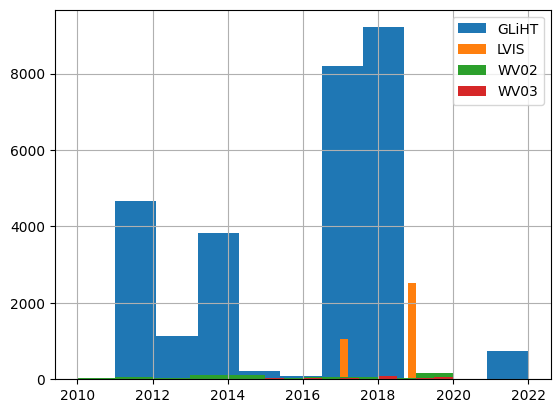

In [270]:
from matplotlib.ticker import MaxNLocator
cols = ['year', 'sensor']

ax = pd.concat([foot_gliht[cols], foot_lvis[cols], foot_srlite[cols]]).groupby('sensor').year.hist(legend=True)

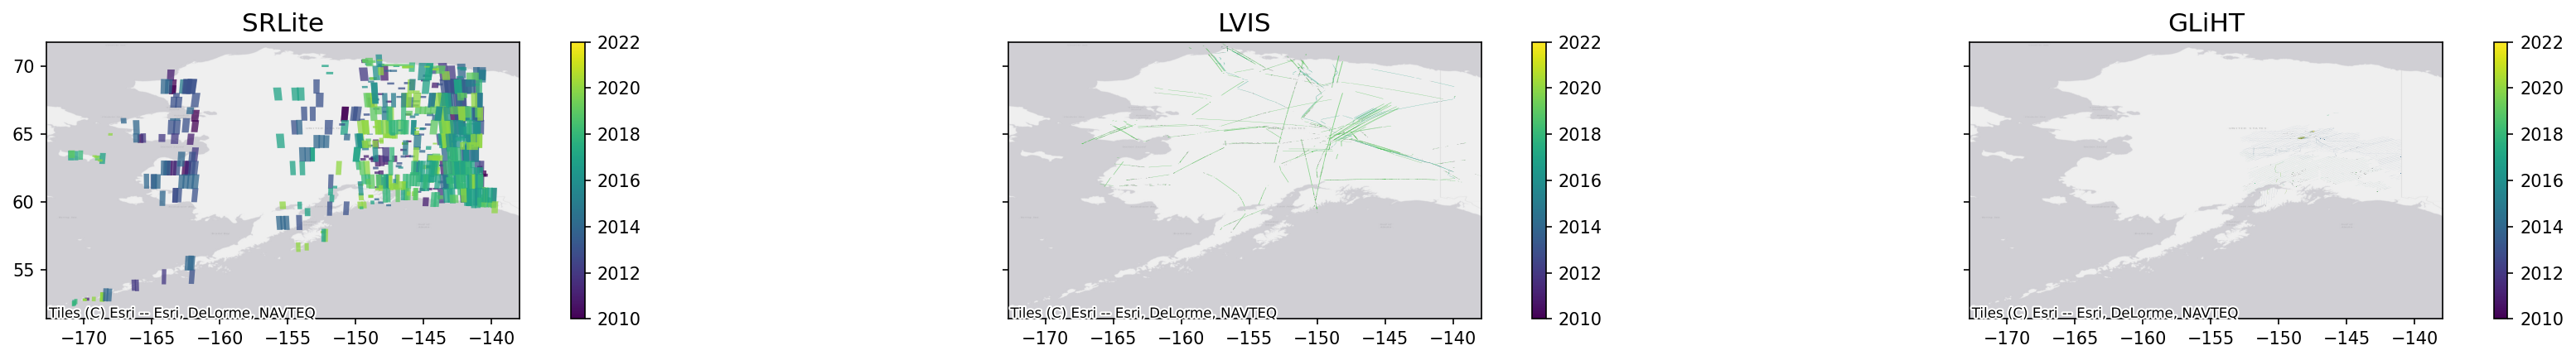

In [275]:
import importlib
importlib.reload(footprintlib)

fig, axa = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, dpi=150, figsize=(24,3))

type_name_list  = list(reversed(['GLiHT', 'LVIS', 'SRLite']))

for n, ax in enumerate(axa.ravel()):
    # This makes leftover axes empty and doesnt return an error
    if n >= len(foot_list):
        ax.axis('off')
        pass
    else:
        ax.set_title(type_name_list[n], fontsize=15)
        ax = footprintlib.MAP_FOOTPRINTS(foot_list[n].cx[-171:-140,50:75], 'year', ax=ax, CMAP='viridis', CAT=False, VMIN=2010, VMAX=2022)

plt.tight_layout()


# Get intersection of SRLite with GLiHT and LVIS
this will tell us from where we can assemble tiles from both IFSAR and GLiHT and where we can then validate with LVIS

In [271]:
foot_intersect_srlite_gliht = gpd.overlay(foot_srlite, foot_gliht, how='intersection')
foot_intersect_srlite_gliht_lvis = gpd.overlay(foot_intersect_srlite_gliht, foot_lvis, how='intersection')

## Here are our candidate model training sites

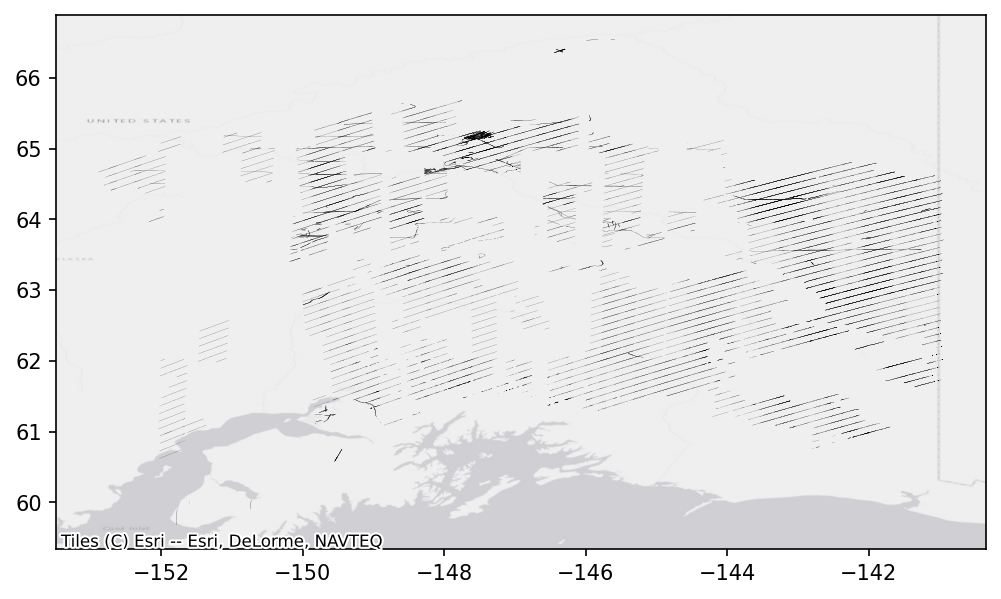

In [277]:
f, ax = plt.subplots(nrows=1, ncols=1,dpi=150, figsize=(8,8)) 

ax = foot_intersect_srlite_gliht.plot(ax=ax, color='black')
ax = ctx.add_basemap(ax, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

## Here are our candidate validation sites

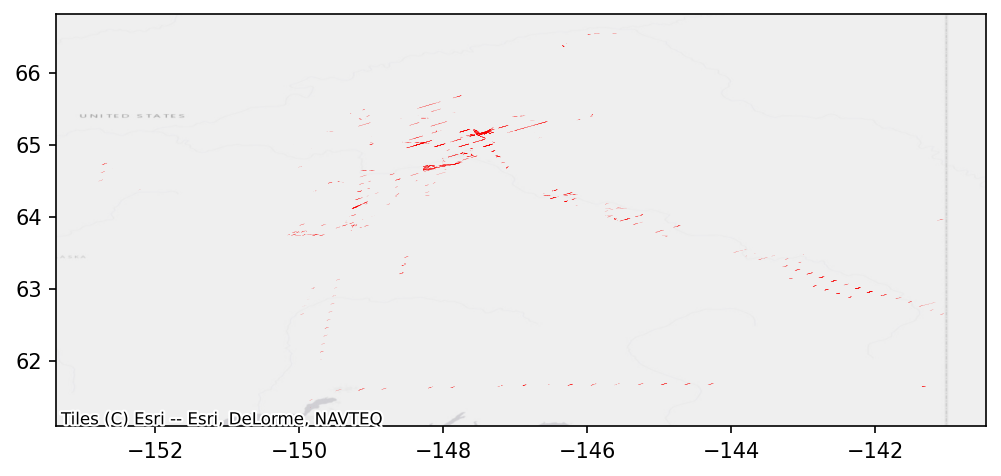

In [276]:
f, ax = plt.subplots(nrows=1, ncols=1,dpi=150, figsize=(8,8)) 

#ax = foot_intersect_srlite_gliht.plot(ax=ax, color='black')
ax = foot_intersect_srlite_gliht_lvis.plot(ax=ax, color='red')
ax = ctx.add_basemap(ax, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

In [273]:
foot_intersect_srlite_gliht.to_file(os.path.join(OUTDIR, 'footprints_intersect_srlite_gliht.gpkg'), driver = 'GPKG')
foot_intersect_srlite_gliht_lvis.to_file(os.path.join(OUTDIR, 'footprints_intersect_srlite_gliht_lvis.gpkg'), driver = 'GPKG')